# States of waterpoints in Tanzania

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
data_path = 'data'
df = pd.concat([
    pd.read_csv(f'{data_path}/train.csv', index_col='id'), 
    pd.read_csv(f'{data_path}/test.csv', index_col='id'),
])

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
    
class LatLonImputer(TransformerMixin):
    
    def __init__(self):
        self.lga_latlon = {
            'Bariadi': (-2.807838, 33.988149),
            'Geita': (-2.878836, 32.227321),
            'Magu': (-2.591117, 33.439851),
        }
        
    def transform(self, df, y=None):
        X = df.copy()
        mask = X.longitude < 20
        for lga in X[mask].lga.unique():
            assert lga in self.lga_latlon, f'unknown lga: {lga}'
            lat, lon = self.lga_latlon[lga]
            X.loc[mask & (X.lga == lga), 'latitude'] = lat
            X.loc[mask & (X.lga == lga), 'longitude'] = lon
        return X
    
    def fit(self, df, y=None):
        return self

class NanStringImputer(TransformerMixin):
    
    def transform(self, df, y=None):
        X = df.copy()
        obj_cols = [col for col, dtype in df.dtypes.items() if dtype == 'object']
        for col in obj_cols:
            X.loc[X[col].isna(), col] = 'nan'
        return X
    
    def fit(self, df, y=None):
        return self

In [4]:
num_features = [
    'latitude', 'longitude', 'gps_height',
    'population', 'amount_tsh',
]

cat_features = [
    'funder', 'installer',
    'basin', 'subvillage', 'region', 'lga', 'ward',
    'extraction_type', 'extraction_type_group', 'extraction_type_class',
    'payment', 'payment_type',
    'water_quality',
    'quality_group', 'quantity', 'quantity_group',
    'source', 'source_type', 'source_class',
    'waterpoint_type', 'waterpoint_type_group',
]

In [5]:
from sklearn.preprocessing import QuantileTransformer, LabelEncoder, StandardScaler, MinMaxScaler
from category_encoders import CatBoostEncoder, OrdinalEncoder, CountEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.compose import TransformedTargetRegressor
from pyclustertend import hopkins

num_tranformers = [
    lambda: QuantileTransformer(output_distribution='normal'),
    lambda: QuantileTransformer(output_distribution='uniform'),
    StandardScaler, 
    MinMaxScaler
]

for transformer in num_tranformers:
    feature_pipeline = make_pipeline(
        LatLonImputer(),
        NanStringImputer(),
        make_column_transformer(
            (transformer(), num_features), 
            (make_pipeline(
                CountEncoder(combine_min_nan_groups=True, min_group_size=0.01), 
                transformer(),
            ), cat_features)
        )
    )
    X = feature_pipeline.fit_transform(df)
    print(transformer, hopkins(X, 100))

<function <lambda> at 0x7f5d47b41268> 0.05434806906048658
<function <lambda> at 0x7f5d45d1cb70> 0.09811394524604825
<class 'sklearn.preprocessing._data.StandardScaler'> 0.009693956266650672
<class 'sklearn.preprocessing._data.MinMaxScaler'> 0.03552530331915692


## Clustering

In [6]:
feature_pipeline = make_pipeline(
    LatLonImputer(),
    NanStringImputer(),
    make_column_transformer(
        (StandardScaler(), num_features), 
        (make_pipeline(
            CountEncoder(combine_min_nan_groups=True, min_group_size=0.01), 
            StandardScaler(),
        ), cat_features)
    )
)

In [7]:
X = feature_pipeline.fit_transform(df)

In [8]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize_clusters(X, labels):
    tsne = TSNE(n_components=2, random_state=10)
    pca = PCA(n_components=2, random_state=10)
    X_tsne = tsne.fit_transform(X)
    X_pca = pca.fit_transform(X)
    
    legend = len(set(labels)) < 10
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title('t-SNE')
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='deep', legend=legend)
    
    plt.subplot(1, 2, 2)
    plt.title('PCA')
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='deep', legend=legend)

    plt.show()

### K-Means

  0%|          | 0/6 [00:00<?, ?it/s]

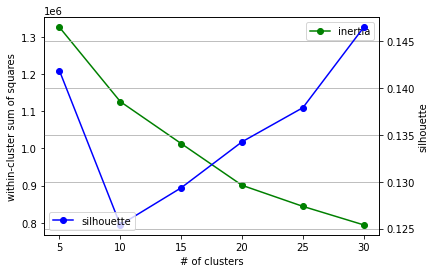

In [9]:
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cluster_nums = np.arange(5, 31, 5)

inertia = []
silhouettes = []
for n in tqdm(cluster_nums):
    algo = KMeans(n_clusters=n)
    labels = algo.fit_predict(X)
    inertia.append(algo.inertia_)
    silhouettes.append(silhouette_score(X, labels))

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(cluster_nums, inertia, 'go-', label='inertia')
ax2.plot(cluster_nums, silhouettes, 'bo-', label='silhouette')

ax1.set_xlabel('# of clusters')
ax1.set_ylabel('within-cluster sum of squares')
ax2.set_ylabel('silhouette')

ax1.legend(loc=0)
ax2.legend(loc=3)
plt.grid()
plt.show()

silhouette = 0.14


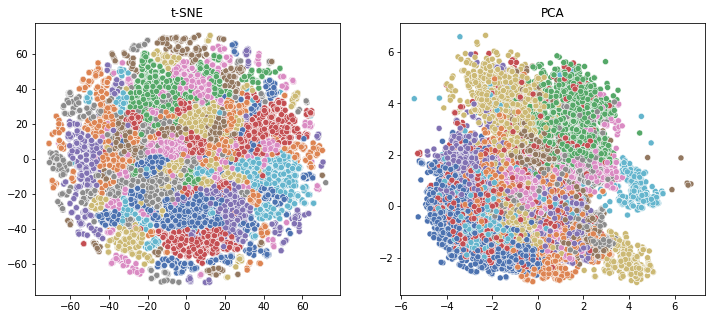

CPU times: user 32min 28s, sys: 5min 7s, total: 37min 36s
Wall time: 14min 28s


In [10]:
%%time

from sklearn.cluster import KMeans

algo = KMeans(n_clusters=30, n_init=30, max_iter=1000)
algo.fit(X)
labels = algo.predict(X)
print(f'silhouette = {silhouette_score(X, labels):.2f}')
visualize_clusters(X, labels)

### DBSCAN

In [11]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [12]:
nbrs = NearestNeighbors(n_neighbors=10).fit(X)
distance, indices = nbrs.kneighbors(X)
distance = np.sort(distance, axis=0)

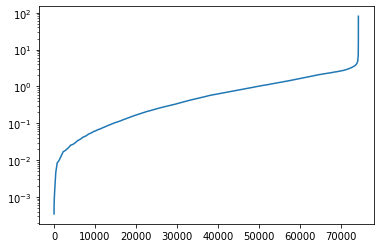

In [13]:
plt.plot(distance[:, 9])
plt.yscale('log')

  0%|          | 0/5 [00:00<?, ?it/s]

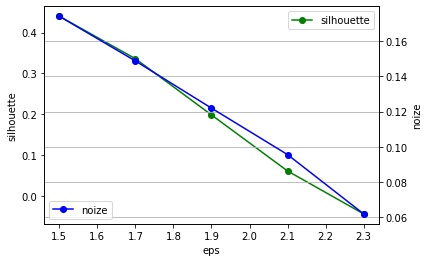

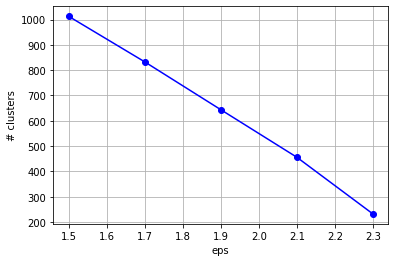

In [14]:
silhouettes = []
noizes = []
n_clusters = []
eps_values = np.arange(1.5, 2.5, 0.2)
for eps in tqdm(eps_values):
    algo = DBSCAN(eps=eps, min_samples=10)
    labels = algo.fit_predict(X)
    core_mask = labels >= 0
    cluster_num = len(set(labels[core_mask]))
    score = silhouette_score(X[core_mask], labels[core_mask]) if cluster_num > 1 else 0
    silhouettes.append(score)
    n_clusters.append(cluster_num)
    noizes.append((labels < 0).mean())

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(eps_values, silhouettes, 'go-', label='silhouette')
ax2.plot(eps_values, noizes, 'bo-', label='noize')

ax1.set_xlabel('eps')
ax1.set_ylabel('silhouette')
ax2.set_ylabel('noize')

ax1.legend(loc=0)
ax2.legend(loc=3)
plt.grid()
plt.show()

plt.plot(eps_values, n_clusters, 'bo-')

plt.xlabel('eps')
plt.ylabel('# clusters')

plt.grid()
plt.show()

In [15]:
from sklearn.metrics import silhouette_score

In [20]:
%%time

algo = DBSCAN(eps=2.0, min_samples=10)
labels = algo.fit_predict(X)
mask = labels >= 0
print(f'# clusters: {max(labels)+1}')
print(f'noize {(labels<0).mean():.1%}')
print(f'silhouette = {silhouette_score(X[mask], labels[mask]):.2f}')

# clusters: 567
noize 10.9%
silhouette = 0.16
CPU times: user 3min 39s, sys: 2min 39s, total: 6min 18s
Wall time: 3min 5s


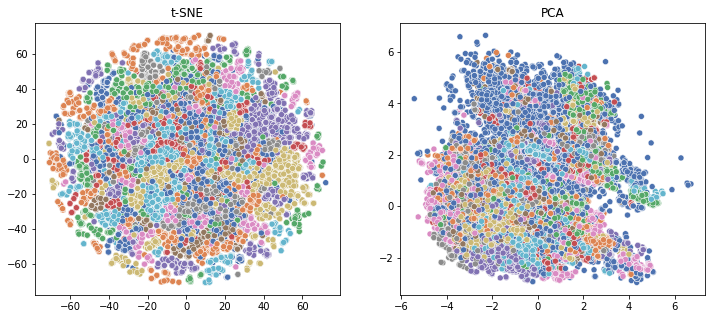

In [21]:
visualize_clusters(X, labels)

In [22]:
pd.DataFrame([
    {
        'method': 'k-means',
        'n_clusters': 30,
        'silhouette': 0.14,
    },
    {
        'method': 'DBSCAN',
        'n_clusters': 567,
        'silhouette': 0.16,
    },
]).set_index('method')

,n_clusters,silhouette
method,,
k-means,30,0.14
DBSCAN,567,0.16


### save labels

In [23]:
idx = df.index.values

In [24]:
X = feature_pipeline.fit_transform(df)

In [25]:
kmeans_labels = KMeans(n_clusters=30, n_init=30, max_iter=1000).fit_predict(X)
dbscan_labels = DBSCAN(eps=2.0, min_samples=10).fit_predict(X)

In [26]:
df = pd.DataFrame({'kmeans': kmeans_labels, 'dbscan': dbscan_labels, 'id': idx}).set_index('id')

In [27]:
df.to_csv('clustering.csv')